In [2]:
# Download Pancancer-normalized from Xena database:  

# # Example below with TCGA BLCA cohort
!mkdir -p ./data
!curl -o ./data/HiSeqV2_PANCAN_BLCA.gz https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.BLCA.sampleMap%2FHiSeqV2_PANCAN.gz
!gunzip ./data/HiSeqV2_PANCAN_BLCA.gz

# # Download Hallmark genes 
# !curl -L -o ./data/hallmarks_signatures.csv https://raw.githubusercontent.com/mahmoodlab/SurvPath/main/datasets_csv/metadata/hallmarks_signatures.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29.2M  100 29.2M    0     0  7495k      0  0:00:03  0:00:03 --:--:-- 7494k


In [17]:
import pandas as pd 
import os 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# read pan-cancer normalized RNA data from BLCA
df_raw = pd.read_csv('data/HiSeqV2_PANCAN_BLCA', delimiter='\t')

# Hallmark pathways 
hallmarks = pd.read_csv('data/hallmarks_signatures.csv').values.flatten()
hallmarks = hallmarks[~pd.isnull(hallmarks)]
hallmarks = pd.unique(hallmarks)

# Clean provided data
df_clean = pd.read_csv('data_csvs/rna/hallmarks/BLCA/rna_clean.csv', delimiter=',')


In [5]:
folds = [0, 1, 2, 3, 4]
cases_from_folds  = []

for i in folds:
    df2 = pd.read_csv(f'splits/survival/TCGA_BLCA_overall_survival_k={i}/test.csv', delimiter=',')
    df3 = pd.read_csv(f'splits/survival/TCGA_BLCA_overall_survival_k={i}/train.csv', delimiter=',')

    cases_to_keep = list(df2[df2.columns[0]].values.flatten())
    cases_splits3 =list(df3[df3.columns[0]].values.flatten())
    cases_to_keep.extend(cases_splits3)
    print(len(cases_to_keep))
    cases_from_folds.append(set(cases_to_keep))

assert all(s == cases_from_folds[0] for s in cases_from_folds), "Not all sets are the same"

print("All sets in the list are identical.")

423
423
423
423
423
All sets in the list are identical.


In [6]:
print("Nr. of genes in gene sets: ", len(hallmarks))
print("Nr. of patients: ", len(cases_from_folds[0]))

Nr. of genes in gene sets:  4241
Nr. of patients:  359


In [7]:
df_raw_T = df_raw
df_raw_T = df_raw_T.set_index('sample')
df_raw_T = df_raw_T.transpose()
df_raw_T = df_raw_T.sort_index(axis=0)
df_raw_T = df_raw_T.reset_index()

In [8]:
# filter out and transpose
df_raw_filt = df_raw[df_raw['sample'].isin(hallmarks)].reset_index(drop=True)
# print(df_raw_filt)
df_raw_filt = df_raw_filt.rename(columns={'sample': None})
df_raw_filt = df_raw_filt.set_index(None)
# print(df_raw_filt)
df_raw_filt = df_raw_filt.transpose()
# print(df_raw_filt)
df_raw_filt = df_raw_filt.sort_index(axis=0)
# # print(df_raw_filt)
df_raw_filt = df_raw_filt.reset_index()
# print(df_raw_filt)
df_raw_filt = df_raw_filt.rename(columns={'index': 'sample'})
# print(df_raw_filt)
# Drop the samples from the normal tissue
df_filtered = df_raw_filt[~df_raw_filt['sample'].str.endswith('-11')].reset_index(drop=True)

# Keep only the samples from the primary tissue
df_filtered['sample'] = df_filtered['sample'].str.replace(r'-01', '', regex=True)

# Keep only the samples from the splits files; samples used in training
df_filtered_complete = df_filtered[df_filtered['sample'].isin(cases_to_keep)].reset_index(drop=True)

In [9]:
num_rows_raw, num_cols_raw = df_raw.shape
num_rows_raw_T, num_cols_raw_T = df_raw_T.shape
num_rows_filt, num_cols_filt = df_filtered_complete.shape
num_rows_clean, num_cols_clean = df_clean.shape

# -1 to leave out the column displaying the samples
assert num_cols_raw_T - 1 == num_rows_raw
assert num_cols_raw - 1 == num_rows_raw_T

In [10]:
print(f"Number of samples raw: {num_rows_raw_T}")
print(f"Number of genes raw: {num_cols_raw_T - 1}")

print(f"Number of samples filtered: {num_rows_filt}")
print(f"Number of genes filtered: {num_cols_filt - 1}")

print(f"Number of samples clean: {num_rows_clean}")
print(f"Number of genes clean: {num_cols_clean - 1}")

Number of samples raw: 426
Number of genes raw: 20530
Number of samples filtered: 359
Number of genes filtered: 4168
Number of samples clean: 360
Number of genes clean: 4241


In [11]:
df_clean_no_dupl = df_clean[df_clean['Unnamed: 0'].isin(cases_to_keep)].reset_index(drop=True)
df_clean_no_dupl = df_clean_no_dupl[~df_clean_no_dupl['Unnamed: 0'].duplicated()].reset_index(drop=True)
df_clean_no_dupl_halmarks = df_clean_no_dupl.filter(items=np.append('Unnamed: 0', hallmarks))
df_clean_no_dupl_halmarks = df_clean_no_dupl_halmarks[['Unnamed: 0'] + sorted(hallmarks)]

print(df_clean_no_dupl_halmarks)

pd.testing.assert_frame_equal(df_clean_no_dupl_halmarks, df_clean_no_dupl)

       Unnamed: 0      A2M    AAAS   AADAT    ABAT   ABCA1   ABCA2   ABCA3  \
0    TCGA-MV-A51V   6.2453  4.8136  0.4125  1.0151  0.9038  4.0782  2.2452   
1    TCGA-FD-A3SR   8.1870  5.1498  1.9111  5.5877  2.6067  4.0471  2.9281   
2    TCGA-DK-A6B0   5.3709  4.9426  2.3843  3.6042  0.4865  3.7667 -0.1187   
3    TCGA-FD-A5BS   6.1229  3.9242 -1.2142 -1.4305  0.4016  4.0019  0.7664   
4    TCGA-DK-A1AD   6.4474  4.8944  2.1702  2.4225  2.3953  2.1862 -0.7108   
..            ...      ...     ...     ...     ...     ...     ...     ...   
354  TCGA-GV-A3JZ   6.9091  4.8187  2.1509  0.3460  2.3732  2.5658  1.6830   
355  TCGA-4Z-AA7N   8.3368  4.5261  1.9638  3.4569  2.8582  3.7324  1.4281   
356  TCGA-XF-A9SW  10.2781  4.2204  1.2756  0.7579  1.5854  4.1978  1.2147   
357  TCGA-DK-A3WX   5.7189  5.7239  1.9377 -0.8339  2.9413  2.9469 -2.8262   
358  TCGA-G2-AA3C   6.5647  5.3005 -0.1345 -1.3183  1.7954  2.9692 -0.6193   

      ABCA4   ABCA5  ...  ZNF292  ZNF365  ZNF639  ZNF707   ZNFX

In [12]:
# rename sample to Unnamed: 0
df_filtered_complete = df_filtered_complete[['sample'] + sorted(df_filtered_complete.columns.values[1:])]
df_filtered_complete = df_filtered_complete.rename(columns={'sample': 'Unnamed: 0'})


print(df_filtered_complete)

       Unnamed: 0       A2M      AAAS     AADAT      ABAT     ABCA1     ABCA2  \
0    TCGA-2F-A9KO -0.125177  0.433298  2.164059  0.670052 -0.390458 -2.173696   
1    TCGA-2F-A9KP -0.512077  0.073898  1.883459  0.851352 -2.210858 -0.930496   
2    TCGA-2F-A9KQ -0.223577  0.265198  2.289459  1.105152 -0.088358 -1.190596   
3    TCGA-2F-A9KR -1.406577  0.516498  1.282759 -0.585148 -0.632058 -1.446696   
4    TCGA-2F-A9KT -2.455177 -0.194102  1.567059  0.585352  0.265542  0.894504   
..            ...       ...       ...       ...       ...       ...       ...   
354  TCGA-ZF-AA53 -1.055077 -0.145102  0.418859 -3.276148  0.896642 -2.441496   
355  TCGA-ZF-AA58 -0.698277 -0.325702 -0.739941 -3.020748 -0.131958 -1.794596   
356  TCGA-ZF-AA5H -1.169077 -0.537102  0.024059 -4.294048  0.061442 -1.895296   
357  TCGA-ZF-AA5N -3.458077  0.215798  1.432359 -0.339048  1.718842  0.549704   
358  TCGA-ZF-AA5P  3.051423 -0.116902  0.542259 -2.008648 -0.487258 -0.793496   

       ABCA3     ABCA4     

In [13]:
# CHeck for genes that are in hallmarks and in df_clean, but not in raw data
li_raw = []
li_filt = []
for item in df_clean.columns:
    if item in hallmarks:
        if item not in df_raw['sample'].values:
            li_raw.append(item)
        if item not in df_filtered_complete.columns.values:
            li_filt.append(item)

assert set(li_raw) == set(li_filt)
print(li_raw)
print(len(li_raw))

['ACKR1', 'ACKR3', 'ADGRA2', 'ADGRE1', 'ADGRG1', 'ADGRL2', 'ADGRL4', 'AGO2', 'AGO4', 'AK4', 'ALYREF', 'CCP110', 'CCSER2', 'CEP131', 'CMTR1', 'CNTRL', 'COLGALT1', 'CPQ', 'CROCCP2', 'CTPS1', 'CTSL', 'CTSV', 'CXCL8', 'DDX39A', 'DEPTOR', 'DMTN', 'DRC1', 'ECI1', 'ECI2', 'FCMR', 'GPER1', 'HELZ2', 'KAZN', 'KDM7A', 'KMT2D', 'LAMTOR5', 'MMS22L', 'MPC1', 'MPC2', 'MSRB1', 'MVB12A', 'NABP1', 'NELFB', 'NELFCD', 'NELFE', 'NPY4R', 'NT5C3A', 'ORC2', 'ORC5', 'ORC6', 'P3H1', 'PIDD1', 'PKM', 'PRSS2', 'RBSN', 'RMDN3', 'SC5D', 'SCAF4', 'SCAF8', 'SOWAHC', 'SRSF1', 'SRSF10', 'SRSF2', 'SRSF3', 'SRSF6', 'SRSF7', 'TBC1D30', 'TENM2', 'TKFC', 'UGT2B17', 'WRAP73', 'ZC2HC1C', 'ZNF112']
73


In [14]:
brca = ['ACKR1', 'ACKR3', 'ADGRA2', 'ADGRE1', 'ADGRG1', 'ADGRL2', 'ADGRL4', 'AGO2', 'AGO4', 'AK4', 'ALYREF', 'CCP110', 'CCSER2', 'CEP131', 'CMTR1', 'CNTRL', 'COLGALT1', 'CPQ', 'CROCCP2', 'CTPS1', 'CTSL', 'CTSV', 'CXCL8', 'DDX39A', 'DEPTOR', 'DMTN', 'DRC1', 'ECI1', 'ECI2', 'FCMR', 'GPER1', 'HELZ2', 'KAZN', 'KDM7A', 'KMT2D', 'LAMTOR5', 'MMS22L', 'MPC1', 'MPC2', 'MSRB1', 'MVB12A', 'NABP1', 'NELFB', 'NELFCD', 'NELFE', 'NPY4R', 'NT5C3A', 'ORC2', 'ORC5', 'ORC6', 'P3H1', 'PIDD1', 'PKM', 'PRSS2', 'RBSN', 'RMDN3', 'SC5D', 'SCAF4', 'SCAF8', 'SOWAHC', 'SRSF1', 'SRSF10', 'SRSF2', 'SRSF3', 'SRSF6', 'SRSF7', 'TBC1D30', 'TENM2', 'TKFC', 'UGT2B17', 'WRAP73', 'ZC2HC1C', 'ZNF112']
assert brca == li_raw

In [15]:
df_clean_no_dupl_dropped_genes = df_clean_no_dupl.drop(columns=li_raw)
df_sorted_clean = df_clean_no_dupl_dropped_genes.sort_values(by='Unnamed: 0')
df_sorted_clean = df_sorted_clean.reset_index().drop(columns='index')

print(df_sorted_clean)

       Unnamed: 0     A2M    AAAS   AADAT    ABAT   ABCA1   ABCA2   ABCA3  \
0    TCGA-2F-A9KO  6.7436  5.4303  3.4331  3.5411  1.9490  2.6395 -1.1488   
1    TCGA-2F-A9KP  6.5069  5.0934  3.3350  3.8187  0.2998  3.5299  1.6830   
2    TCGA-2F-A9KQ  6.6353  5.1680  3.6195  3.8650  2.2019  3.5959  0.6050   
3    TCGA-2F-A9KR  5.7996  5.6381  2.7029  2.4908  1.8996  3.6737 -0.1828   
4    TCGA-2F-A9KT  5.0553  5.0131  2.9893  3.6543  2.7336  6.0648 -1.0862   
..            ...     ...     ...     ...     ...     ...     ...     ...   
354  TCGA-ZF-AA53  6.4050  4.5862  1.3567 -0.3940  2.9911  2.9205 -1.5105   
355  TCGA-ZF-AA58  6.4895  4.6944  0.5666  0.0718  2.3222  3.7614  0.8408   
356  TCGA-ZF-AA5H  5.8453  4.5117  1.3623 -1.0559  2.5163  3.1749 -1.0559   
357  TCGA-ZF-AA5N  3.7028  4.8425  2.3451  2.2783  3.7464  5.4503 -1.5105   
358  TCGA-ZF-AA5P  9.7813  4.5838  1.5316  1.1050  1.6830  4.1376  2.4597   

      ABCA4   ABCA5  ...  ZNF292  ZNF365  ZNF639  ZNF707   ZNFX1   ZNRF4  \

In [16]:
pd.testing.assert_frame_equal(df_sorted_clean, df_filtered_complete)

AssertionError: DataFrame.iloc[:, 1] (column name="A2M") are different

DataFrame.iloc[:, 1] (column name="A2M") values are different (100.0 %)
[index]: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]
[left]:  [6.7436, 6.5069, 6.6353, 5.7996, 5.0553, 7.4911, 5.2646, 8.3368, 5.9493, 6.528, 5.4562, 6.5314, 6.4585, 5.5607, 4.7624, 4.1318, 6.231, 6.3295, 4.844, 6.2782, 5.2762, 4.764, 7.027, 6.8123, 6.64748289508, 7.28458075112, 5.8949906863, 5.8724, 8.5797, 5.8228, 5.2661, 6.0924, 4.6456, 7.5971, 6.6727, 6.0184, 5.2107, 7.4282, 4.9055, 6.8722, 6.8828, 6.7331, 4.7597, 7.4576, 5.5756, 4.7576, 5.1248, 6.3873, 5.3263, 7.0922, 4.809, 5.1571, 5.8184, 4.5442, 5.4738, 6.3744, 5.0635, 4.9241, 7.1653, 6.639, 4.7209, 5.7393, 5.5308, 6.4315, 7.6691, 5.4266, 7.5945, 6.7047, 6.2763, 5.9736, 8.2286, 7.0356, 3.832, 6.6913, 5.7782, 6.0907, 7.6491, 6.3502, 5.8919, 6.1667, 5.5429, 6.4474, 5.093, 9.2005, 5.4932, 8.6148, 7.3699, 5.9246, 7.713, 4.7645, 6.3688, 6.5868, 2.4332, 6.5671, 9.2332, 5.677, 7.302, 8.1994, 6.0762, 4.6035, ...]
[right]: [-0.125177300039, -0.512077300039, -0.223577300039, -1.40657730004, -2.45517730004, 0.487122699961, -2.43797730004, 1.42392269996, -0.840977300039, -0.0910773000391, -1.49077730004, -0.474477300039, -1.15787730004, -1.66937730004, -2.53387730004, -2.92737730004, -0.844877300039, -0.493577300039, -1.82917730004, -0.910677300039, -2.03947730004, -2.91887730004, -0.131877300039, -1.08067730004, 0.826222699961, 0.817022699961, -0.369277300039, -1.46717730004, 1.67602269996, -0.690777300039, -1.42087730004, -0.610177300039, -2.41457730004, 0.584722699961, -0.185177300039, -0.463377300039, -1.89787730004, 0.616322699961, -2.28267730004, -0.00427730003909, -0.318177300039, -0.118677300039, -2.37727730004, 0.711022699961, -1.69097730004, -2.03577730004, -1.44017730004, -0.758777300039, -1.32667730004, 0.185822699961, -2.05257730004, -1.57877730004, -0.870377300039, -2.59757730004, -1.69057730004, 0.499322699961, -1.39957730004, -1.11817730004, 0.758522699961, -0.0750773000391, -1.80147730004, -0.255477300039, -0.762577300039, -0.730477300039, 1.16462269996, -2.26587730004, 0.0923226999609, 0.311922699961, -0.133677300039, -1.12847730004, 1.51752269996, 0.320422699961, -3.12227730004, 0.0540226999609, -0.879077300039, -0.452677300039, 0.797922699961, -0.876177300039, 0.199822699961, -0.632377300039, -1.36567730004, 0.0154226999609, -1.65187730004, 2.08862269996, -1.44487730004, 1.49282269996, 0.572922699961, -1.27637730004, 0.608322699961, -2.33617730004, -0.248877300039, -0.0393773000391, -4.54827730004, -0.617577300039, 2.28292269996, -1.66927730004, 0.210322699961, 1.40782269996, -1.29147730004, -2.35897730004, ...]
At positional index 0, first diff: 6.7436 != -0.125177300039

# Make Plots

In [18]:
#Boxplot per sample
def plot_box_per_sample(df_provided, df_downloaded):

    # Transpose to have genes in rows and samples in columns
    df_provided_per_sample = df_provided.head(10).T.drop("Unnamed: 0", axis=0)
    # df_downloaded_per_sample = df_downloaded.head(5)
    print(" FOR DATA THET PROVIDED")
    print("Mean: ", df_provided_per_sample.mean(axis=0))
    print("Std: ", df_provided_per_sample.std(axis=0))

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_provided_per_sample)
    plt.title("Distribution of Expression Values per Sample")
    plt.xlabel("Samples")
    plt.ylabel("Expression Value")
    plt.xticks(rotation=45)
    plt.show()

    # Transpose to have genes in rows and samples in columns
    df_downloaded_per_sample = df_downloaded.head(10).T.drop("Unnamed: 0", axis=0)
    print(" FOR DATA THET PROVIDED")
    print("Mean: ", df_downloaded_per_sample.mean(axis=0))
    print("Std: ", df_downloaded_per_sample.std(axis=0))

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_downloaded_per_sample)
    plt.title("Distribution of Expression Values per Sample")
    plt.xlabel("Samples")
    plt.ylabel("Expression Value")
    plt.xticks(rotation=45)
    plt.show()

 FOR DATA THET PROVIDED
Mean:  0    3.268621
1    2.874586
2    2.765438
3    3.186029
4    2.846932
5     3.14758
6    2.916245
7    3.400471
8    2.688129
9    2.713787
dtype: object
Std:  0     3.88125
1    4.191092
2    4.210248
3    3.908282
4    4.260664
5     4.11714
6    4.160381
7    3.744236
8    4.390676
9    4.032527
dtype: object


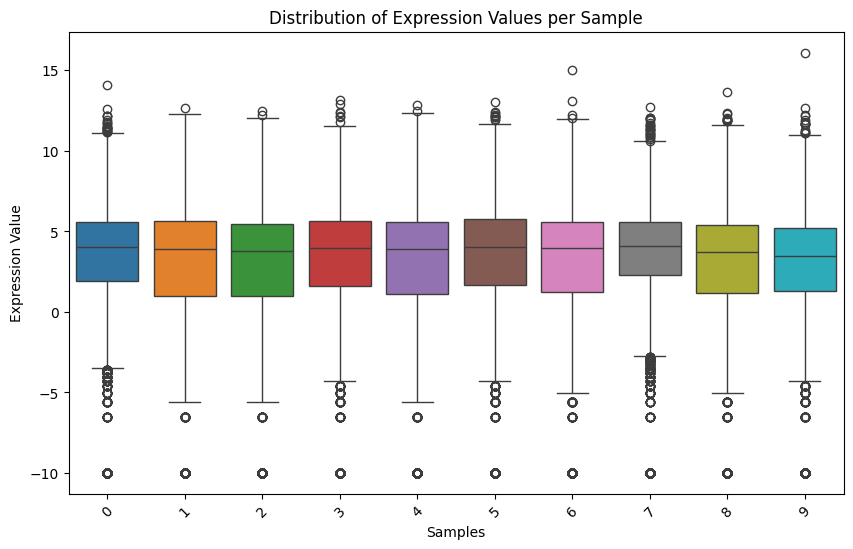

 FOR DATA THET PROVIDED
Mean:  0    0.239099
1   -0.270038
2   -0.199062
3    -0.01988
4   -0.314524
5    0.017173
6   -0.266987
7    0.326784
8   -0.147994
9    0.143621
dtype: object
Std:  0    1.429288
1    1.681912
2     1.69726
3    1.496161
4    1.657524
5    1.499085
6    1.599417
7    1.347328
8     1.58044
9    1.529248
dtype: object


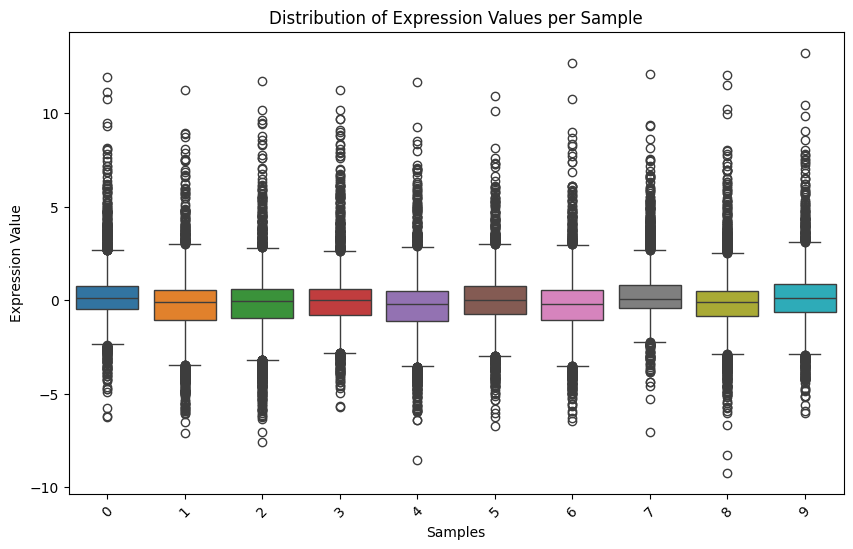

In [19]:
plot_box_per_sample(df_sorted_clean, df_filtered_complete)

In [21]:
#Boxplot per gene
def plot_box_per_gene(df_provided, df_downloaded):

    # Transpose to have genes in rows and samples in columns
    df_provided_per_gene = df_provided.iloc[:, 1:11]
    df_downloaded_per_gene = df_downloaded.iloc[:, 1:11]

    print(" FOR DATA THEY PROVIDED")
    print("Mean: ", df_provided_per_gene.mean(axis=0))
    print("Std: ", df_provided_per_gene.std(axis=0))

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_provided_per_gene)
    plt.title("Distribution of Expression Values per Gene")
    plt.xlabel("Samples")
    plt.ylabel("Expression Value")
    plt.xticks(rotation=45)
    plt.show()

    print(" FOR DATA WE DOWNLOADED")
    print("Mean: ", df_downloaded_per_gene.mean(axis=0))
    print("Std: ", df_downloaded_per_gene.std(axis=0))

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_downloaded_per_gene)
    plt.title("Distribution of Expression Values per Gene")
    plt.xlabel("Samples")
    plt.ylabel("Expression Value")
    plt.xticks(rotation=45)
    plt.show()

 FOR DATA THEY PROVIDED
Mean:  A2M      6.226255
AAAS     4.928493
AADAT    1.842369
ABAT     2.038854
ABCA1    1.939661
ABCA2    3.758731
ABCA3    0.227332
ABCA4   -1.369978
ABCA5    2.408957
ABCA6    0.092794
dtype: float64
Std:  A2M      1.341150
AAAS     0.459930
AADAT    1.357037
ABAT     1.757206
ABCA1    1.097370
ABCA2    1.145320
ABCA3    1.773028
ABCA4    2.706684
ABCA5    1.087616
ABCA6    2.247959
dtype: float64


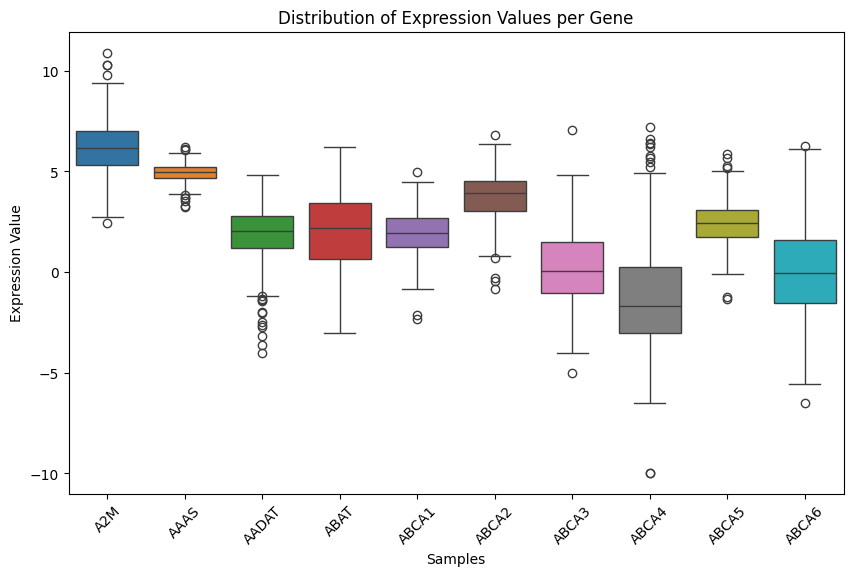

 FOR DATA WE DOWNLOADED
Mean:  A2M     -0.774545
AAAS     0.062380
AADAT    0.611032
ABAT    -0.851411
ABCA1   -0.300246
ABCA2   -1.077634
ABCA3   -2.929776
ABCA4    0.478073
ABCA5   -0.019003
ABCA6    0.110034
dtype: float64
Std:  A2M      1.425806
AAAS     0.411456
AADAT    1.386473
ABAT     1.867258
ABCA1    1.019930
ABCA2    1.135034
ABCA3    1.969315
ABCA4    2.647452
ABCA5    1.191164
ABCA6    2.560876
dtype: float64


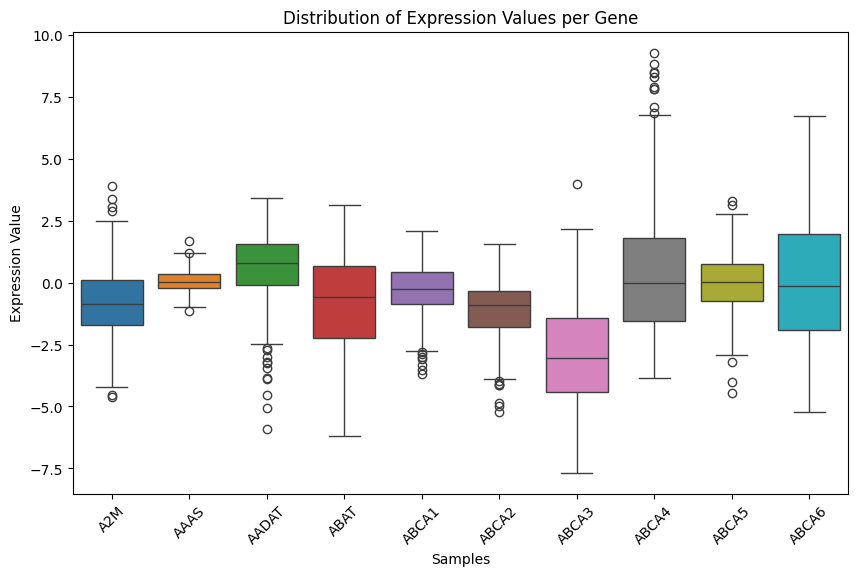

In [22]:
plot_box_per_gene(df_sorted_clean, df_filtered_complete)